## Test for equal numbers of files between test, train, and val sets at awk and npz levels

In [1]:
prefix_match = {
    "JZ0": 'user.mswiatlo.39955613',
    "JZ1": 'user.mswiatlo.39955646',
    "JZ2": 'user.mswiatlo.39955678',
    "JZ3": 'user.mswiatlo.39955704',
    "JZ4": 'user.mswiatlo.39955735',
    "JZ5": 'user.mswiatlo.39955768',
    "JZ6": 'user.mswiatlo.39955825',
}

prefix_to_set = {j:i for i,j in prefix_match.items()}

import sys
from pathlib import Path
REPO_PATH = Path.home() / "workspace/jetpointnet"
SCRIPT_PATH = REPO_PATH / "python_scripts"
sys.path.append(str(SCRIPT_PATH))


In [2]:
import os
from data_processing.jets.preprocessing_header import AWK_SAVE_LOC, NPZ_SAVE_LOC, FILES_DIR, MAX_SAMPLE_LENGTH, INCLUDE_SETS_TO_NPZ
import re

# Specify the directory path
dirs_names = ['train', 'val', 'test']

root_dir_lens = {}
for dir in os.listdir(FILES_DIR):
    entries = os.listdir(FILES_DIR + dir)
    number_of_files = sum(os.path.isfile(os.path.join(FILES_DIR + dir, entry)) for entry in entries)
    dir_short_name = re.search(r'JZ[0-9]|JZ10', dir).group()
    root_dir_lens[dir_short_name] = number_of_files
    print(f'{dir_short_name} contains {number_of_files} files with 500 events')

root_files = sum(root_dir_lens.values())
print(f"FOUND {root_files} root files containing {root_files * 500:10,} events")

print("-" * 27)

# Get a list of all entries in the directory
awk_file_numbers = []
for dir in dirs_names:
    directory_path = AWK_SAVE_LOC / dir
    entries = os.listdir(directory_path)
    number_of_files = sum(os.path.isfile(os.path.join(directory_path, entry)) for entry in entries)
    awk_file_numbers.append(number_of_files)
    print(f"AWK {dir:<5} contains {number_of_files} files")
print(f"AWK {'total':<5} contains {sum(awk_file_numbers)} files")

print("-" * 27)

npz_file_numbers = []
for dir in dirs_names:
    directory_path = NPZ_SAVE_LOC / dir
    entries = os.listdir(directory_path)
    number_of_files = sum(os.path.isfile(os.path.join(directory_path, entry)) for entry in entries)
    npz_file_numbers.append(number_of_files)
    print(f"NPZ {dir:<5} contains {number_of_files} files")
print(f"NPZ {'total':<5} contains {sum(npz_file_numbers)} files")

print("-" * 27)


print(f'ROOT to AWK is {100 * awk_file_numbers[0]/root_files:4.1f}% complete')
print(f'AWK  to NPZ is {100 * npz_file_numbers[0]/awk_file_numbers[0]:4.1f}% complete')

print("-" * 27)

ImportError: cannot import name 'FILES_DIR' from 'data_processing.jets.preprocessing_header' (/home/jhimmens/workspace/jetpointnet/python_scripts/data_processing/jets/preprocessing_header.py)

## Get file sizes of the root, awk, and npz files

In [ ]:
import subprocess

def get_directory_size(directory):
    # Run the 'du' command to get the size of the directory
    # The '-s' option gives the total size of the directory
    # The '-k' option lists the size in kilobytes
    result = subprocess.run(['du', '-sk', directory], capture_output=True, text=True)
    # The output is in the format "size directory_name", we split on whitespace
    return int(result.stdout.split()[0])
    
root_size = get_directory_size(FILES_DIR)
print(f"ROOT {'':<4} is {(root_size/1024/1024):4.0f}GB large")

print("-" * 25)

awk_file_sizes = []
for dir in dirs_names:
    directory_path = AWK_SAVE_LOC / dir
    size = get_directory_size(directory_path)
    awk_file_sizes.append(size)
    print(f"AWK {dir:<5} is {(size/1024/1024):4.0f}GB large")
print(f"NPZ {'total':<5} is {(sum(awk_file_sizes)/1024/1024):4.0f}GB large")

print("-" * 25)

npz_file_sizes = []
for dir in dirs_names:
    directory_path = NPZ_SAVE_LOC / dir
    size = get_directory_size(directory_path)
    npz_file_sizes.append(size)
    print(f"NPZ {dir:<5} is {(size/1024/1024):4.0f}GB large")
print(f"NPZ {'total':<5} is {(sum(npz_file_sizes)/1024/1024):4.0f}GB large")

print("-" * 25)

print(f"TOTAL {'':<3} is {((root_size + sum(npz_file_sizes) + sum(awk_file_sizes))/1024/1024):4.0f}GB large")

ROOT      is  160GB large
-------------------------
AWK train is  115GB large
AWK val   is   63GB large
AWK test  is   31GB large
NPZ total is  209GB large
-------------------------
NPZ train is  160GB large
NPZ val   is   88GB large
NPZ test  is    0GB large
NPZ total is  248GB large
-------------------------
TOTAL     is  617GB large


## Find event sample lengths

In [ ]:
from pathlib import Path
import json
import re
json_loc = Path(AWK_SAVE_LOC).parent / "metadata" / "sample_length_calcs.json"
with open(json_loc, 'r') as f:
    results = json.load(f)

In [ ]:
lengths_dict = {f"JZ{i}": [] for i in range(7)}

for key, value in results.items():
    for i in value:
        lengths_dict[prefix_to_set[i[1][:len('user.mswiatlo.39955613')]]].append(max(i[0]))

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


JZ0 95th percentile: Excluded
JZ1 95th percentile: 391.0
JZ2 95th percentile: 633.0
JZ3 95th percentile: 830.0
JZ4 95th percentile: 949.2
JZ5 95th percentile: 1028.95
JZ6 95th percentile: 1073.75
Max Sample Length is 1129
Number of included files: 7882
32 files EXLUDED from last sample length search


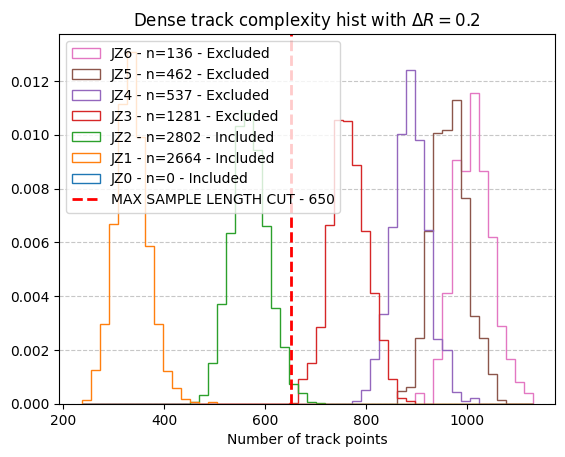

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


rates = lengths_dict.values()
included_dict = {True: "Included",
                 False: "Excluded"}
labels = [f"{i} - n={len(lengths_dict[i])} - {included_dict[i in INCLUDE_SETS_TO_NPZ]} " for i in lengths_dict.keys()]
#plt.hist(rates, label=labels, bins=50, histtype='step', stacked=True, fill=False)
plt.hist(rates, label=labels, bins=50, histtype='step', fill=False, density=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.yscale('log')
plt.title("Dense track complexity hist with $\Delta R =0.2$")
plt.xlabel("Number of track points")


plt.axvline(x=MAX_SAMPLE_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX SAMPLE LENGTH CUT - {MAX_SAMPLE_LENGTH}')
plt.legend()

for i in lengths_dict.keys():
    print(f"{i} 95th percentile: {np.percentile(lengths_dict[i], 95) if  len(lengths_dict[i]) != 0 else 'Excluded'}")


print(f"Max Sample Length is {max([max(lengths_dict[f'JZ{i}']) for i in range(7) if len(lengths_dict[f'JZ{i}']) != 0])}")
print(f"Number of included files: {sum([len(lengths_dict[f'JZ{i}']) for i in range(7)])}")
print(f"{(sum(awk_file_numbers)-sum([len(lengths_dict[f'JZ{i}']) for i in range(7)]))} files EXLUDED from last sample length search")

In [ ]:
import os

# Directory to check
directory = '/fast_scratch_1/atlas/pflow/20240614/user.mswiatlo.801167.Py8EG_A14NNPDF23LO_jj_JZ2.recon.ESD.e8514_e8528_s4185_s4114_r14977_2024.06.14.1_mltree.root'

# Prefix to check for
prefix = 'user.mswiatlo.39955678'

def all_files_start_with_prefix(directory, prefix):
    # Check if the path is a directory
    if not os.path.isdir(directory):
        return "Error: The provided path is not a directory."

    # List all files in the directory
    try:
        files = os.listdir(directory)
    except FileNotFoundError:
        return "Error: Directory not found."
    except PermissionError:
        return "Error: Permission denied."

    # Check if each file starts with the prefix
    for file in files:
        if not file.startswith(prefix):
            return False
    return True

# Use the function and print the result
result = all_files_start_with_prefix(directory, prefix)
print(result)

True


In [ ]:
for i in lengths_dict.keys():
    print(f"Set {i} is {100 * len(lengths_dict[i])/(3*root_dir_lens[i]):6.2f}% complete")

Set JZ0 is   0.00% complete
Set JZ1 is  90.52% complete
Set JZ2 is  97.90% complete
Set JZ3 is 100.00% complete
Set JZ4 is 100.00% complete
Set JZ5 is 100.00% complete
Set JZ6 is  30.22% complete
